In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

/Users/shreemit/miniforge3/envs/leaseGPT/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('merge_movies.csv')
movies.head()

,movieId,title,genres,year,imdbId,tmdbId
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,114709.0,862.0
1,2,Jumanji,Adventure|Children|Fantasy,1995,113497.0,8844.0
2,3,Grumpier Old Men,Comedy|Romance,1995,113228.0,15602.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,114885.0,31357.0
4,5,Father of the Bride Part II,Comedy,1995,113041.0,11862.0


In [3]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


In [4]:
user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [5]:
print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Mean number of ratings for a given user: 165.30.


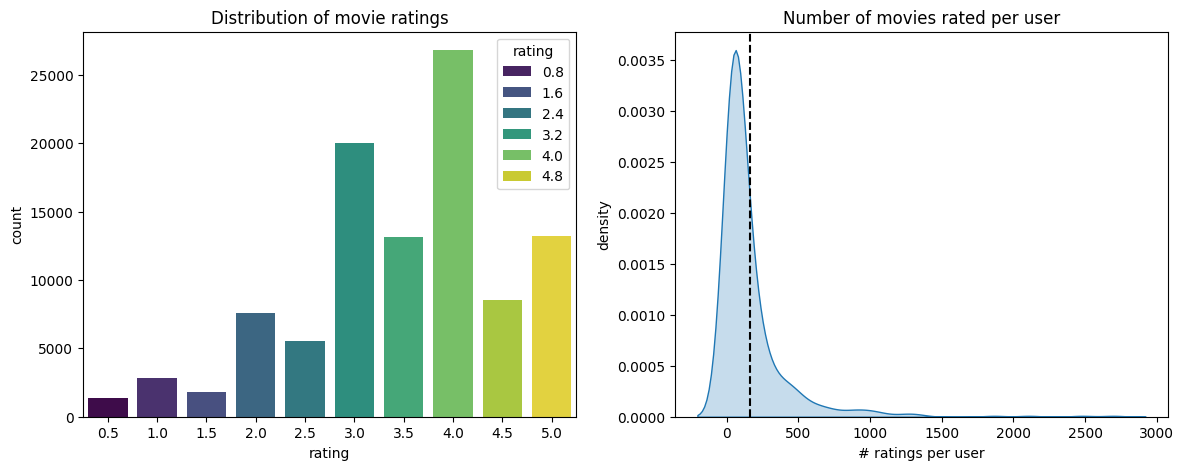

In [6]:
# sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis", hue=ratings['rating'])
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], fill=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

In [7]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == lowest_rated]['title'], movies.loc[movies['movieId'] == highest_rated]['title']

(2689    Gypsy
 Name: title, dtype: object,
 48    Lamerica
 Name: title, dtype: object)

In [8]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [9]:
movie_stats

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429
...,...,...
193581,1,4.000000
193583,1,3.500000
193585,1,3.500000


In [10]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [22]:
movie_stats.columns, movies.columns, bayesian_avg_ratings.columns

(Index(['movieId', 'count', 'mean', 'bayesian_avg', 'title', 'year', 'genres'], dtype='object'),
 Index(['movieId', 'title', 'genres', 'year', 'imdbId', 'tmdbId'], dtype='object'),
 Index(['movieId', 'bayesian_avg'], dtype='object'))

In [12]:
movie_stats = movie_stats.merge(movies[['movieId', 'title', 'year', 'genres']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title,year,genres
277,318,317,4.429022,4.392070,"Shawshank Redemption, The",1994,Crime|Drama
659,858,192,4.289062,4.236457,"Godfather, The",1972,Crime|Drama
2224,2959,218,4.272936,4.227052,Fight Club,1999,Action|Crime|Drama|Thriller
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope,1977,Action|Adventure|Sci-Fi
46,50,204,4.237745,4.190567,"Usual Suspects, The",1995,Crime|Mystery|Thriller


In [13]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title,year,genres
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control,1997,Action|Romance|Thriller
2679,3593,19,1.657895,2.224426,Battlefield Earth,2000,Action|Sci-Fi
1372,1882,33,1.954545,2.267268,Godzilla,1998,Action|Sci-Fi|Thriller
1144,1499,27,1.925926,2.296800,Anaconda,1997,Action|Adventure|Thriller
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace,1987,Action|Adventure|Sci-Fi


## Collaborative Filtering with k-Nearest Neighbors

In [14]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [15]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)


In [16]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [17]:
from scipy.sparse import save_npz

save_npz('user_item_matrix.npz', X)

In [18]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar movie ID's
    """
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [19]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}")
print("You should watch:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story
You should watch:
Toy Story 2
Jurassic Park
Independence Day
Star Wars: Episode IV - A New Hope
Forrest Gump
Lion King, The
Star Wars: Episode VI - Return of the Jedi
Mission: Impossible
Groundhog Day
Back to the Future


In [20]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1
similar_ids = find_similar_movies(movie_id, X, k=10, metric="euclidean")

movie_title = movie_titles[movie_id]
print(f"Because you watched {movie_title}:")
for i in similar_ids:
    print(movie_titles[i])

Because you watched Toy Story:
Toy Story 2
Mission: Impossible
Independence Day
Bug's Life, A
Nutty Professor, The
Willy Wonka & the Chocolate Factory
Babe
Groundhog Day
Mask, The
Honey, I Shrunk the Kids


In [23]:
user_ratings = ratings[ratings['userId'] == 1]

In [24]:
user_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903
